Download the Following PSC Datasets:

1. hESC -> endothelial
H9 hESC cell line

    Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3814891

  * GSM3814891	10X_day_12_H9

2. 2D gastruloids

    Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM8157261
  * GSM8157261	Hour_96_rep1

3. Embryoid bodies

  Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3573650
  * nicotine-exposed_EB scRNA-seq [N]

In [42]:
## Install
!pip install scanpy scipy umap-learn leidenalg
!pip install infercnvpy
!pip install pykalman

# Import
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

from pykalman import KalmanFilter
from joblib import Parallel, delayed
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter1d

import seaborn as sns

from scipy.stats import ks_2samp
from tqdm.auto import tqdm

In [43]:
# Load the Datasets

# H9 endothelial (Day 12)
adata_h9 = sc.read_10x_h5("GSM3814891_day12_filtered_gene_bc_matrices_h5.h5")
# 2D Gastruloids (Hour 96 rep1)
adata_gastruloid = sc.read_10x_h5("GSM8157261_4830-KJ-3_filtered_feature_bc_matrix.h5")
# Embryoid body (N sample)
adata_eb = sc.read_10x_h5("GSM3573650_N_filtered_gene_bc_matrices_h5.h5")

In [44]:
# Print Datasets

print(adata_h9)            # H9 endothelial
print(adata_gastruloid)    # Gastruloid
print(adata_eb)            # Embryoid body

print("H9:", adata_h9.shape)
print("Gastruloid:", adata_gastruloid.shape)
print("Embryoid body:", adata_eb.shape)

AnnData object with n_obs × n_vars = 6492 × 33694
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 6990 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
AnnData object with n_obs × n_vars = 5646 × 33694
    var: 'gene_ids'
H9: (6492, 33694)
Gastruloid: (6990, 36601)
Embryoid body: (5646, 33694)


### Necessary Methods and Driver Function

In [45]:
import numpy as np
import scipy.ndimage as ndi
from joblib import Parallel, delayed

def gaussian_smooth_1d(vec, sigma=2):
    """Fast Gaussian 1‑D smoothing of a 1‑D NumPy array."""
    return ndi.gaussian_filter1d(vec, sigma=sigma)

# --------------------------------------------------------
def coarse_smooth(expr, gene_stride=5, cell_stride=1, sigma=2):
    """
    1. Down‑sample genes/cells.
    2. Smooth on the coarse grid.
    3. Interpolate back to full size.
    """
    # --- 1) choose subsampled indices
    gene_idx = np.arange(0, expr.shape[1], gene_stride)
    cell_idx = np.arange(0, expr.shape[0], cell_stride)

    expr_sub = expr[np.ix_(cell_idx, gene_idx)]

    # --- 2) smooth on coarse matrix (cells × genes)
    expr_sub_smooth = np.apply_along_axis(gaussian_smooth_1d,
                                          1,               # over genes
                                          expr_sub,
                                          sigma=sigma)

    # --- 3) interpolate back (linear) per cell
    full = np.empty_like(expr, dtype=np.float32)
    for i, row in enumerate(cell_idx):
        full_row = np.interp(np.arange(expr.shape[1]),
                             gene_idx,
                             expr_sub_smooth[i])
        full[row] = full_row

    # if we skipped cells, copy coarse rows into missing rows
    if cell_stride > 1:
        for i in range(expr.shape[0]):
            if i not in cell_idx:
                nearest = cell_idx[np.argmin(np.abs(cell_idx - i))]
                full[i] = full[nearest]

    return full

# --------------------------------------------------------
def blockwise_fine_smooth(expr, sigma=2, block_size=1000, n_jobs=4):
    """
    Optional second‑pass fine filter in blocks of cells.
    Much faster than smoothing the entire dense matrix at once.
    """
    n_cells = expr.shape[0]
    blocks = [(i, min(i+block_size, n_cells)) for i in range(0, n_cells, block_size)]

    def smooth_block(beg, end):
        sub = expr[beg:end]
        return np.apply_along_axis(gaussian_smooth_1d, 1, sub, sigma=sigma)

    smoothed_blocks = Parallel(n_jobs=n_jobs)(
        delayed(smooth_block)(beg, end) for beg, end in blocks
    )
    return np.vstack(smoothed_blocks)

In [46]:
# def select_baseline(adata, layer="smoothed", min_cells=5, n_clusters_start=6, top_n_clusters=2, n_jobs=4):
#   # may need to edit to include cell line mode for iPSCs - assumes normal subpopulations exist, or selects low variance cells as baseline
#   """
#   Select a baseline for CNV analysis using multiple low-variance clusters and incorporates
#   Gaussian Mixture Models (GMM) for variance estimation. Uses `AnnData` object for input and output.

#   Parameters:
#   - adata: AnnData object containing the expression data in the "smoothed" layer.
#   - min_cells: minimum number of cells allowed in a cluster
#   - n_clusters_start: initial number of clusters to cut the tree
#   - top_n_clusters: how many low-variance clusters to combine for baseline
#   - n_jobs: number of parallel jobs to run for GMM fitting

#   Returns:
#   - adata: AnnData object with baseline information stored in `.obs` and baseline in `.layers['baseline']`
#   """
#   adata2 = adata.copy()

#   # Ensure that the "smoothed" layer exists in the adata object
#   if layer not in adata2.layers:
#       raise ValueError("The AnnData object must have a 'smoothed' layer.")

#   # Extract the smoothed expression matrix
#   norm_mat_smooth = adata2.layers[layer] # cells x genes

#   print("Clustering cells to find baseline...")

#   # def select_baseline(..., mode="tumor"):
#   #     if mode == "cell_line":
#   #         # Instead of clustering, select the cells with lowest genome-wide variance
#   #         genome_variance = np.var(norm_mat_smooth, axis=1)
#   #         selected_cells = np.argsort(genome_variance)[:100]  # e.g., top 100 least variant
#   #     else:
#   #         # existing clustering + GMM logic
#   #         ...


#   # 1. Hierarchical clustering
#   dists = pdist(norm_mat_smooth, metric='euclidean')
#   linkage_matrix = linkage(dists, method='ward')

#   # 2. Try starting with more clusters and merge down if necessary
#   n_clusters = n_clusters_start
#   cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

#   # Check that no cluster is too small
#   while np.any(np.bincount(cluster_labels)[1:] < min_cells):
#       n_clusters -= 1
#       if n_clusters < 2:
#           warnings.warn("Cannot cluster into reasonable groups; proceeding with 2 clusters.")
#           cluster_labels = fcluster(linkage_matrix, 2, criterion='maxclust')
#           break
#       cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

#   print(f"Clustered into {n_clusters} clusters.")

#   # 3. Fit a GMM to each cluster's expression data to estimate variance
#   def fit_gmm_to_cluster(cluster_id):
#       """Fit a GMM to the expression data of a single cluster."""
#       cell_indices = np.where(cluster_labels == cluster_id)[0]
#       cluster_expr = norm_mat_smooth[cell_indices, :] # cells x genes

#       # Fit a GMM to the cluster expression data (per gene)
#       gmm = GaussianMixture(n_components=3, covariance_type='diag')  # Using 3 components for GMM; might need to change "diag" to "full" if results are weird (but computationally expensive)
#       gmm.fit(cluster_expr)  # Fit GMM on the transposed data (cells x genes)

#       return cluster_id, np.mean(gmm.covariances_)

#   # Run the GMM fitting in parallel across clusters
#   cluster_vars = Parallel(n_jobs=n_jobs)(delayed(fit_gmm_to_cluster)(clust_id) for clust_id in np.unique(cluster_labels))

#   np.save('/content/drive/MyDrive/cluster_vars.npy', cluster_vars)
#   # 4. Sort clusters by variance (using GMM variance)
#   cluster_vars.sort(key=lambda x: x[1])  # sort by GMM variance
#   selected_clusters = [clust_id for clust_id, _ in cluster_vars[:top_n_clusters]]

#   print(f"Selected clusters {selected_clusters} as baseline candidates.")

#   # 5. Pool cells from selected clusters
#   selected_cells = np.where(np.isin(cluster_labels, selected_clusters))[0]

#   if len(selected_cells) == 0:
#       raise ValueError("No cells selected for baseline computation!")

#   # 6. Compute baseline: median across selected cells
#   baseline = np.median(norm_mat_smooth[selected_cells, :], axis=0) # compute median of each gene across baseline cells
#   # baseline = baseline.reshape(1, -1)  # Reshape to (1, number_of_genes)
#   # baseline = np.repeat(baseline, adata2.shape[0], axis=0) # Repeat for each cell
#   np.save('/content/drive/MyDrive/baseline.npy', baseline)
#   print(f"Baseline computed using {len(selected_cells)} cells.")

#   # Store baseline and selected cell indices in the AnnData object
#   adata2.obs["selected_cells"] = np.isin(np.arange(adata2.shape[0]), selected_cells)
#   adata2.var["baseline"] = baseline


#   # Store cluster labels in .obs (can be useful for downstream analysis)
#   adata2.obs["cluster_labels"] = cluster_labels

#   return adata2



from scipy.cluster.hierarchy import linkage, cut_tree
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

def synthetic_baseline(norm_mat: np.ndarray, gene_names: list[str], cell_names: list[str], min_cells: int = 10, max_k: int = 6, seed: int = 123):
    """
    Estimate synthetic baseline using intra-normal GMM-like approach.

    Parameters:
        norm_mat (np.ndarray): smoothed matrix (genes × cells)
        gene_names (list): gene identifiers (rows of norm_mat)
        cell_names (list): cell identifiers (columns of norm_mat)
        min_cells (int): minimum number of cells per cluster
        max_k (int): initial number of clusters
        seed (int): seed for reproducibility

    Returns:
        expr_relat_df (pd.DataFrame): relative expression matrix (genes × cells)
        syn_df (pd.DataFrame): synthetic baseline (genes × clusters)
        cl_labels (np.ndarray): cluster labels per cell (same order as input)
    """
    np.random.seed(seed)
    norm_df = pd.DataFrame(norm_mat, index=gene_names, columns=cell_names)

    # Compute pairwise distances between cells
    dist = squareform(pdist(norm_df.T, metric='euclidean'))

    # Hierarchical clustering
    linkage_matrix = linkage(dist, method="ward")
    k = max_k
    cl_labels = cut_tree(linkage_matrix, n_clusters=k).flatten()

    # Reduce k until all clusters have min_cells
    while np.any(np.bincount(cl_labels) < min_cells):
        k -= 1
        if k < 2:
            break
        cl_labels = cut_tree(linkage_matrix, n_clusters=k).flatten()

    # Prepare outputs
    expr_relat = []
    syn_cols = []
    valid_clusters = np.unique(cl_labels)

    for i in valid_clusters:
        cell_mask = cl_labels == i
        cluster_data = norm_df.iloc[:, cell_mask]

        if cluster_data.shape[1] < min_cells:
            continue

        # Per-gene standard deviation
        sd = cluster_data.std(axis=1)

        # Sample synthetic baseline from N(0, sd)
        syn_norm = np.random.normal(loc=0, scale=sd)
        syn_cols.append(pd.Series(syn_norm, index=norm_df.index, name=f"cluster_{i}"))

        # Subtract from cluster cells
        expr_cluster = cluster_data.subtract(syn_norm, axis=0)
        expr_relat.append(expr_cluster)

    # Concatenate outputs
    expr_relat_df = pd.concat(expr_relat, axis=1)
    syn_df = pd.concat(syn_cols, axis=1)

    return expr_relat_df, syn_df, cl_labels


In [47]:
# Preprocessing and filtering step

# Limit noise, doublets, and low quality reads for more efficient downstream analysis
def cleanAd(ad, filter_mt=True, set_pct_counts_mt=20, filter_counts=True, set_min_genes=500, set_max_counts=30000, set_min_cells=3):
  ad.var['mt'] = ad.var_names.str.startswith('MT-')
  ribo_prefix = ("RPS","RPL")
  ad.var['ribo'] = ad.var_names.str.startswith(ribo_prefix)
  sc.pp.calculate_qc_metrics(ad, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

  adClean = ad.copy()

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'wspace':0.25}, constrained_layout=True)
  ax1_dict = sc.pl.scatter(adClean, x='total_counts', y='pct_counts_mt', ax=ax1, show=False)
  ax2_dict = sc.pl.scatter(adClean, x='total_counts', y='n_genes_by_counts',ax=ax2, show=False)
  ax3_dict = sc.pl.scatter(adClean, x='pct_counts_ribo', y='n_genes_by_counts',ax=ax3, show=False)
  fig.suptitle('Before filtering')
  plt.show()

  if filter_mt:
    adClean = adClean[adClean.obs['pct_counts_mt']<set_pct_counts_mt,:].copy()
  if filter_counts:
    sc.pp.filter_cells(adClean, min_genes=set_min_genes)
    sc.pp.filter_cells(adClean, max_counts=set_max_counts)
    sc.pp.filter_genes(adClean, min_cells=set_min_cells) # Remove outlier genes

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'wspace':0.25}, constrained_layout=True)
  ax1_dict = sc.pl.scatter(adClean, x='total_counts', y='pct_counts_mt', ax=ax1, show=False)
  ax2_dict = sc.pl.scatter(adClean, x='total_counts', y='n_genes_by_counts',ax=ax2, show=False)
  ax3_dict = sc.pl.scatter(adClean, x='pct_counts_ribo', y='n_genes_by_counts',ax=ax3, show=False)
  fig.suptitle('After filtering')
  plt.show()

  print(adClean.shape)
  return adClean

  # Normalize to correct for cell-to-cell variation
def normalizeAd(ad):
  adNorm = ad.copy()
  adNorm.layers['counts'] = adNorm.X.copy()
  sc.pp.normalize_total(adNorm , target_sum=1e4)
  sc.pp.log1p(adNorm)
  return adNorm

# Detection rate
def filter_dr(adata, low_dr=0.02, high_dr=0.98):
  expression_matrix = adata.layers['counts'].toarray() if 'counts' in adata.layers else adata.X.toarray()
  detection_rate = np.sum(expression_matrix > 0, axis=0) / expression_matrix.shape[0]
  filtered_genes = detection_rate > low_dr
  ad_filtered = adata[:, filtered_genes].copy()
  print(f"{filtered_genes.sum()} genes passed low detection rate filtering")

  # quality check
  num_genes = ad_filtered.shape[1]
  if num_genes < 7000:
      print("WARNING: low data quality; assigned low_dr to high_dr...")
      high_dr = low_dr
      warning = "low data quality"
  else:
      warning = "data quality is ok"
      high_dr = high_dr
  print(warning)

  return ad_filtered, high_dr

In [48]:
# removes cell cycle genes
def remove_cell_cycle(adata):
  adata = adata.copy()

  # Define S-phase genes
  s_genes = [
    'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1',
    'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1',
    'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76',
    'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51',
    'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM',
    'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'
  ]

# Define G2/M-phase genes
  g2m_genes = [
    'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A',
    'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF',
    'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB',
    'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP',
    'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5',
    'CDCA3', 'HN1', 'CENPA'
    ]

# Combine all cell cycle genes
  cc_genes = s_genes + g2m_genes

  adata = adata[:, ~adata.var_names.isin(cc_genes)].copy()
  print(f"Shape after removing cell cycle genes: {adata.shape}")
  return adata

def remove_hla(adata):
  hla_genes = [gene for gene in adata.var_names if gene.startswith('HLA-')]
  print(f"Found {len(hla_genes)} HLA genes to remove.")
  adata = adata[:, ~adata.var_names.isin(hla_genes)].copy()
  return adata


def second_filter(adata, min_genes_per_chr):
  print("Filtering low-quality cells based on chromosomal coverage...")

  # Check and Infer Chromosome:
  if 'chromosome' not in adata.var.columns:
        # Try to infer chromosome from gene names (e.g., 'chr1_...')
        try:
            adata.var['chromosome'] = adata.var.index.str.extract('(chr[0-9XY]+)', expand=False)
            print("Inferred 'chromosome' from gene names.")
        except AttributeError:
            raise KeyError("Column 'chromosome' not found in adata.var and could not be inferred from gene names.")

  genes = adata.var
  expr = adata.layers['counts'].toarray() if 'counts' in adata.layers else adata.X.toarray()

  good_cells = []
  for i in range(expr.shape[0]):
      cell_expr = expr[i, :]
      nonzero_idx = cell_expr > 0
      cell_chr = genes['chromosome'][nonzero_idx]
      chr_rle = cell_chr.value_counts()
      if (chr_rle.min() >= min_genes_per_chr):
          good_cells.append(i)

  adata = adata[good_cells, :].copy()
  print(f"Remaining {adata.n_obs} cells after filtering")

  # Variance stabilization and mean-centering
  print("Applying sqrt(x)+sqrt(x+1) transform and mean-centering...")
  expr = adata.layers['counts'].toarray() if 'counts' in adata.layers else adata.X.toarray()
  expr = np.log1p(np.sqrt(expr) + np.sqrt(expr+1))
  expr = expr - expr.mean(axis=1, keepdims=True)
  adata.layers['counts'] = expr

  return adata

In [49]:
# takes too long
# # Smoothening steps
# def smooth_cell(x):
#   # Initialize a simple Kalman filter like DLM in R
#   kf = KalmanFilter(
#       transition_matrices=[1],    # 1st order polynomial model
#       observation_matrices=[1],
#       initial_state_mean=x[0],
#       initial_state_covariance=1,
#       observation_covariance=0.1,  # dV=0.16 (noise variance)
#       transition_covariance=0.001   # dW=0.001 (process variance)
#   )
#   smoothed_state_means, _ = kf.smooth(x)
#   smoothed = smoothed_state_means[:,0]  # Extract smoothed means
#   smoothed = smoothed - np.mean(smoothed)
#   return smoothed

# def smooth_matrix(expr, n_jobs=4):
#   smoothed = Parallel(n_jobs=n_jobs)(delayed(smooth_cell)(expr[:,i]) for i in range(expr.shape[1]))
#   smoothed_mat = np.column_stack(smoothed)
#   return smoothed_mat


def fast_gaussian_smooth(x, sigma=2):
    """Fast smoothing of a 1D array with a simple Gaussian filter."""
    smoothed = gaussian_filter1d(x, sigma=sigma)
    smoothed = smoothed - np.mean(smoothed)  # Center
    return smoothed

def smooth_matrix(expr, gaussian_sigma=2, use_kalman=False, n_jobs=-1):
    """
    Fast smoothing of expression matrix.

    Parameters:
    - expr: 2D np.array (genes x cells)
    - gaussian_sigma: smoothing strength for Gaussian
    - use_kalman: whether to polish with Kalman after Gaussian
    - n_jobs: number of parallel jobs

    Returns:
    - smoothed_mat: 2D np.array
    """
    def smooth_one_cell(i):
        x = expr[:,i]
        x_smooth = fast_gaussian_smooth(x, sigma=gaussian_sigma)
        if use_kalman:
            x_smooth = kalman_polish(x_smooth)
        return x_smooth

    smoothed = Parallel(n_jobs=n_jobs)(
        delayed(smooth_one_cell)(i) for i in range(expr.shape[1])
    )
    smoothed_mat = np.column_stack(smoothed)
    return smoothed_mat

### Method for InferCNV

In [50]:
import itertools
import re
from collections.abc import Sequence
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import scipy.ndimage
import scipy.sparse
from anndata import AnnData
from scanpy import logging
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from infercnvpy._util import _ensure_array


def infercnv(
    adata: AnnData,
    *,
    reference_key: str | None = None,
    reference_cat: None | str | Sequence[str] = None,
    reference: np.ndarray | None = None,
    lfc_clip: float = 3,
    window_size: int = 100,
    step: int = 10,
    dynamic_threshold: float | None = 2,
    exclude_chromosomes: Sequence[str] | None = ("chrX", "chrY"),
    chunksize: int = 5000,
    n_jobs: int | None = None,
    inplace: bool = True,
    layer: str | None = None,
    key_added: str = "cnv",
    calculate_gene_values: bool = False,
) -> None | tuple[dict, scipy.sparse.csr_matrix, np.ndarray | None]:
    """Infer Copy Number Variation (CNV) by averaging gene expression over genomic regions.

    This method is heavily inspired by `infercnv <https://github.com/broadinstitute/inferCNV/>`_
    but more computationally efficient. The method is described in more detail
    in on the :ref:`infercnv-method` page.

    There, you can also find instructions on how to :ref:`prepare input data <input-data>`.

    Parameters
    ----------
    adata
        annotated data matrix
    reference_key
        Column name in adata.obs that contains tumor/normal annotations.
        If this is set to None, the average of all cells is used as reference.
    reference_cat
        One or multiple values in `adata.obs[reference_key]` that annotate
        normal cells.
    reference
        Directly supply an array of average normal gene expression. Overrides
        `reference_key` and `reference_cat`.
    lfc_clip
        Clip log fold changes at this value
    window_size
        size of the running window (number of genes in to include in the window)
    step
        only compute every nth running window where n = `step`. Set to 1 to compute
        all windows.
    dynamic_threshold
        Values `< dynamic threshold * STDDEV` will be set to 0, where STDDEV is
        the stadard deviation of the smoothed gene expression. Set to `None` to disable
        this step.
    exclude_chromosomes
        List of chromosomes to exclude. The default is to exclude genosomes.
    chunksize
        Process dataset in chunks of cells. This allows to run infercnv on
        datasets with many cells, where the dense matrix would not fit into memory.
    n_jobs
        Number of jobs for parallel processing. Default: use all cores.
        Data will be submitted to workers in chunks, see `chunksize`.
    inplace
        If True, save the results in adata.obsm, otherwise return the CNV matrix.
    layer
        Layer from adata to use. If `None`, use `X`.
    key_added
        Key under which the cnv matrix will be stored in adata if `inplace=True`.
        Will store the matrix in `adata.obsm["X_{key_added}"] and additional information
        in `adata.uns[key_added]`.
    calculate_gene_values
        If True per gene CNVs will be calculated and stored in `adata.layers["gene_values_{key_added}"]`.
        As many genes will be included in each segment the resultant per gene value will be an average of the genes included in the segment.
        Additionally not all genes will be included in the per gene CNV, due to the window size and step size not always being a multiple of
        the number of genes. Any genes not included in the per gene CNV will be filled with NaN.
        Note this will significantly increase the memory and computation time, it is recommended to decrease the chunksize to ~100 if this is set to True.


    Returns
    -------
    Depending on inplace, either return the smoothed and denoised gene expression
    matrix sorted by genomic position, or add it to adata.
    """
    if not adata.var_names.is_unique:
        raise ValueError("Ensure your var_names are unique!")
    if {"chromosome", "start", "end"} - set(adata.var.columns) != set():
        raise ValueError(
            "Genomic positions not found. There need to be `chromosome`, `start`, and `end` columns in `adata.var`. "
        )

    var_mask = adata.var["chromosome"].isnull()
    if np.sum(var_mask):
        logging.warning(f"Skipped {np.sum(var_mask)} genes because they don't have a genomic position annotated. ")  # type: ignore
    if exclude_chromosomes is not None:
        var_mask = var_mask | adata.var["chromosome"].isin(exclude_chromosomes)

    tmp_adata = adata[:, ~var_mask]
    reference = _get_reference(adata, reference_key, reference_cat, reference)[:, ~var_mask]
    print("got reference")

    expr = tmp_adata.X if layer is None else tmp_adata.layers[layer]

    if scipy.sparse.issparse(expr):
        expr = expr.tocsr()

    var = tmp_adata.var.loc[:, ["chromosome", "start", "end"]]  # type: ignore

    chr_pos, chunks, convolved_dfs = zip(
        *process_map(
            _infercnv_chunk,
            [expr[i : i + chunksize, :] for i in range(0, adata.shape[0], chunksize)],
            itertools.repeat(var),
            itertools.repeat(reference),
            itertools.repeat(lfc_clip),
            itertools.repeat(window_size),
            itertools.repeat(step),
            itertools.repeat(dynamic_threshold),
            itertools.repeat(calculate_gene_values),
            tqdm_class=tqdm,
            max_workers=cpu_count() if n_jobs is None else n_jobs,
        ),
        strict=False,
    )

    res = scipy.sparse.vstack(chunks)

    chr_pos = chr_pos[0]

    if calculate_gene_values:
        per_gene_df = pd.concat(convolved_dfs, axis=0)
        # Ensure the DataFrame has the correct row index
        per_gene_df.index = adata.obs.index
        # Ensure the per gene CNV matches the adata var (genes) index, any genes
        # that are not included in the CNV will be filled with NaN
        per_gene_df = per_gene_df.reindex(columns=adata.var_names, fill_value=np.nan)
        # This needs to be a numpy array as colnames are too large to save in anndata
        per_gene_mtx = per_gene_df.values
    else:
        per_gene_mtx = None

    if inplace:
        adata.obsm[f"X_{key_added}"] = res
        adata.uns[key_added] = {"chr_pos": chr_pos}

        if calculate_gene_values:
            adata.layers[f"gene_values_{key_added}"] = per_gene_mtx

    else:
        return chr_pos, res, per_gene_mtx


def _natural_sort(l: Sequence):
    """Natural sort without third party libraries.

    Adapted from: https://stackoverflow.com/a/4836734/2340703
    """

    def convert(text):
        return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key):
        return [convert(c) for c in re.split("([0-9]+)", key)]

    return sorted(l, key=alphanum_key)


def _running_mean(
    x: np.ndarray | scipy.sparse.spmatrix,
    n: int = 50,
    step: int = 10,
    gene_list: list = None,
    calculate_gene_values: bool = False,
) -> tuple[np.ndarray, pd.DataFrame | None]:
    """
    Compute a pyramidially weighted running mean.

    Densifies the matrix. Use `step` and `chunksize` to save memory.

    Parameters
    ----------
    x
        matrix to work on
    n
        Length of the running window
    step
        only compute running windows every `step` columns, e.g. if step is 10
        0:99, 10:109, 20:119 etc. Saves memory.
    gene_list
        List of gene names to be used in the convolution
    calculate_gene_values
        If True per gene CNVs will be calculated and stored in `adata.layers["gene_values_{key_added}"]`.
    """
    if n < x.shape[1]:  # regular convolution: the filter is smaller than the #genes
        r = np.arange(1, n + 1)
        pyramid = np.minimum(r, r[::-1])
        smoothed_x = np.apply_along_axis(
            lambda row: np.convolve(row, pyramid, mode="valid"),
            axis=1,
            arr=x,
        ) / np.sum(pyramid)

        ## get the indices of the genes used in the convolution
        convolution_indices = get_convolution_indices(x, n)[np.arange(0, smoothed_x.shape[1], step)]
        ## Pull out the genes used in the convolution
        convolved_gene_names = gene_list[convolution_indices]
        smoothed_x = smoothed_x[:, np.arange(0, smoothed_x.shape[1], step)]

        if calculate_gene_values:
            convolved_gene_values = _calculate_gene_averages(convolved_gene_names, smoothed_x)
        else:
            convolved_gene_values = None

        return smoothed_x, convolved_gene_values

    else:  # If there is less genes than the window size, set the window size to the number of genes and perform a single convolution
        n = x.shape[1]  # set the filter size to the number of genes
        r = np.arange(1, n + 1)
        ## As we are only doing one convolution the values should be equal
        pyramid = np.array([1] * n)
        smoothed_x = np.apply_along_axis(
            lambda row: np.convolve(row, pyramid, mode="valid"),
            axis=1,
            arr=x,
        ) / np.sum(pyramid)

        if calculate_gene_values:
            ## As all genes are used the convolution the values are identical for all genes
            convolved_gene_values = pd.DataFrame(np.repeat(smoothed_x, len(gene_list), axis=1), columns=gene_list)
        else:
            convolved_gene_values = None

        return smoothed_x, convolved_gene_values


def _calculate_gene_averages(
    convolved_gene_names: np.ndarray,
    smoothed_x: np.ndarray,
) -> pd.DataFrame:
    """
    Calculate the average value of each gene in the convolution

    Parameters
    ----------
    convolved_gene_names
        A numpy array with the gene names used in the convolution
    smoothed_x
        A numpy array with the smoothed gene expression values

    Returns
    -------
    convolved_gene_values
        A DataFrame with the average value of each gene in the convolution
    """
    ## create a dictionary to store the gene values per sample
    gene_to_values = {}
    # Calculate the number of genes in each convolution, will be same as the window size default=100
    length = len(convolved_gene_names[0])
    # Convert the flattened convolved gene names to a list
    flatten_list = list(convolved_gene_names.flatten())

    # For each sample in smoothed_x find the value for each gene and store it in a dictionary
    for sample, row in enumerate(smoothed_x):
        # Create sample level in the dictionary
        if sample not in gene_to_values:
            gene_to_values[sample] = {}
        # For each gene in the flattened gene list find the value and store it in the dictionary
        for i, gene in enumerate(flatten_list):
            if gene not in gene_to_values[sample]:
                gene_to_values[sample][gene] = []
            # As the gene list has been flattend we can use the floor division of the index
            # to get the correct position of the gene to get the value and store it in the dictionary
            gene_to_values[sample][gene].append(row[i // length])

    for sample in gene_to_values:
        for gene in gene_to_values[sample]:
            gene_to_values[sample][gene] = np.mean(gene_to_values[sample][gene])

    convolved_gene_values = pd.DataFrame(gene_to_values).T
    return convolved_gene_values


def get_convolution_indices(x, n):
    indices = []
    for i in range(x.shape[1] - n + 1):
        indices.append(np.arange(i, i + n))
    return np.array(indices)


def _running_mean_by_chromosome(
    expr, var, window_size, step, calculate_gene_values
) -> tuple[dict, np.ndarray, pd.DataFrame | None]:
    """Compute the running mean for each chromosome independently. Stack the resulting arrays ordered by chromosome.

    Parameters
    ----------
    expr
        A gene expression matrix, appropriately preprocessed
    var
        The var data frame of the associated AnnData object
    window_size
        size of the running window (number of genes in to include in the window)
    step
        only compute every nth running window where n = `step`. Set to 1 to compute
        all windows.

    Returns
    -------
    chr_start_pos
        A Dictionary mapping each chromosome to the index of running_mean where
        this chromosome begins.
    running_mean
        A numpy array with the smoothed gene expression, ordered by chromosome
        and genomic position
    """
    chromosomes = _natural_sort([x for x in var["chromosome"].unique() if x.startswith("chr") and x != "chrM"])

    running_means = [
        _running_mean_for_chromosome(chr, expr, var, window_size, step, calculate_gene_values) for chr in chromosomes
    ]

    running_means, convolved_dfs = zip(*running_means, strict=False)

    chr_start_pos = {}
    for chr, i in zip(chromosomes, np.cumsum([0] + [x.shape[1] for x in running_means]), strict=False):
        chr_start_pos[chr] = i

    ## Concatenate the gene dfs
    if calculate_gene_values:
        convolved_dfs = pd.concat(convolved_dfs, axis=1)

    return chr_start_pos, np.hstack(running_means), convolved_dfs


def _running_mean_for_chromosome(chr, expr, var, window_size, step, calculate_gene_values):
    genes = var.loc[var["chromosome"] == chr].sort_values("start").index.values
    tmp_x = expr[:, var.index.get_indexer(genes)]
    x_conv, convolved_gene_values = _running_mean(
        tmp_x, n=window_size, step=step, gene_list=genes, calculate_gene_values=calculate_gene_values
    )

    return x_conv, convolved_gene_values

from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

def baseline_synthetic(norm_mat: pd.DataFrame, min_cells: int = 10, max_k: int = 6, seed: int = 123):
    """
    Estimate baseline copy numbers using synthetic normal profiles.

    Parameters:
    - norm_mat: genes x cells (pandas DataFrame)
    - min_cells: minimum number of cells per cluster
    - max_k: initial number of clusters to try
    - seed: random seed for reproducibility

    Returns:
    - expr_relat: gene expression relative to synthetic baseline
    - syn_normal: synthetic normal reference (genes × clusters)
    - cl_labels: array of cluster labels per cell
    """
    np.random.seed(seed)

    # 1. Compute distance between cells (columns)
    dist = squareform(pdist(norm_mat.T, metric="euclidean"))

    # 2. Hierarchical clustering (Ward's method)
    from scipy.cluster.hierarchy import linkage, cut_tree
    linkage_matrix = linkage(dist, method="ward")

    k = max_k
    cl_labels = cut_tree(linkage_matrix, n_clusters=k).flatten()

    while np.any(np.bincount(cl_labels) < min_cells):
        k -= 1
        if k < 2:
            break
        cl_labels = cut_tree(linkage_matrix, n_clusters=k).flatten()

    # 3. For each cluster, generate synthetic normal and relative expression
    cluster_ids = np.unique(cl_labels)
    syn_list = []
    relat_list = []

    for i in cluster_ids:
        cluster_cells = norm_mat.iloc[:, cl_labels == i]
        if cluster_cells.shape[1] < min_cells:
            continue
        std_dev = cluster_cells.std(axis=1)
        syn_norm = np.random.normal(loc=0, scale=std_dev)
        relat = cluster_cells.subtract(syn_norm, axis=0)
        relat_list.append(relat.T)
        syn_list.append(pd.Series(syn_norm, index=norm_mat.index, name=f"cluster_{i}"))

    expr_relat = pd.concat(relat_list, axis=0)
    syn_normal = pd.concat(syn_list, axis=1)  # genes × clusters

    return expr_relat, syn_normal, cl_labels


def _get_reference(
    adata: AnnData,
    reference_key: str | None,
    reference_cat: None | str | Sequence[str],
    reference: np.ndarray | None,
) -> np.ndarray:
    """Parameter validation extraction of reference gene expression.

    If multiple reference categories are given, compute the mean per
    category.

    Returns a 2D array with reference categories in rows, cells in columns.
    If there's just one category, it's still a 2D array.
    """
    if reference is None:
        if reference_key is None or reference_cat is None:
            logging.warning(
                "Using mean of all cells as reference. For better results, "
                "provide either `reference`, or both `reference_key` and `reference_cat`. "
            )  # type: ignore
            # change this to adjust how reference is obtained
            reference = np.mean(adata.X, axis=0)

            # logging.warning("Computing reference using synthetic baseline method.")

            # norm_mat = pd.DataFrame(
            #     adata.X.T,  # genes × cells
            #     index=adata.var_names,
            #     columns=adata.obs_names,
            # )

            # expr_relat, syn_normal, cl_labels = baseline_synthetic(norm_mat, min_cells=10)

            # # Set synthetic baseline as reference (clusters × genes)
            # reference = syn_normal.T.to_numpy()  # shape: (n_clusters, n_genes)

        else:
            obs_col = adata.obs[reference_key]
            if isinstance(reference_cat, str):
                reference_cat = [reference_cat]
            reference_cat = np.array(reference_cat)
            reference_cat_in_obs = np.isin(reference_cat, obs_col)
            if not np.all(reference_cat_in_obs):
                raise ValueError(
                    "The following reference categories were not found in "
                    "adata.obs[reference_key]: "
                    f"{reference_cat[~reference_cat_in_obs]}"
                )

            reference = np.vstack([np.mean(adata.X[obs_col.values == cat, :], axis=0) for cat in reference_cat])

    if reference.ndim == 1:
        reference = reference[np.newaxis, :]

    if reference.shape[1] != adata.shape[1]:
        raise ValueError("Reference must match the number of genes in AnnData. ")

    return reference


### Running inferKat Pipeline

In [51]:
# driver function for copykat dupe
def inferKat(adata, set_min_genes=500, low_dr = 0.02, high_dr = 0.98, min_genes_per_chr = 5, ks_cutoff = 0.2):

  # preprocess
  print("Step 1: read and filter data ...")
  ad_clean = cleanAd(adata, set_min_genes)
  ad_norm = normalizeAd(ad_clean)
  ad_filt, high_dr = filter_dr(ad_norm, low_dr, high_dr)

  # annotate genes and secondary filtering
  print("Step 2: annotate gene coordinates and secondary filtering genes...")
  ad_filt.var_names_make_unique()  # Ensure gene symbols (var_names) are unique
  cnv.io.genomic_position_from_biomart(ad_filt, biomart_gene_id="hgnc_symbol", species="hsapiens", inplace = True)
  ad_filt2 = remove_cell_cycle(ad_filt)
  ad_filt3 = remove_hla(ad_filt2)
  ad_filt4 = second_filter(ad_filt3, min_genes_per_chr)
  # sort by position
  ad_filt4.var = ad_filt4.var.sort_values(by=["chromosome", "start"])
  ad_filt4 = ad_filt4[:, ad_filt4.var.index]

  #------------------------------------------------------------
  print("Step 3: coarse Gaussian smoothing (fast)…")

  expr_dense = (
      ad_filt4.layers['counts'].toarray()
      if 'counts' in ad_filt4.layers
      else ad_filt4.X.toarray()
  )

  # --- Fast coarse pass (5× fewer genes) ---
  expr_coarse = coarse_smooth(expr_dense,
                              gene_stride=5,   # keep 1/5 genes
                              cell_stride=1,   # keep all cells
                              sigma=2)

  # --- Optional fine pass by blocks (makes edges nice) ---
  expr_smooth = blockwise_fine_smooth(expr_coarse,
                                      sigma=1,      # lighter blur
                                      block_size=1000,
                                      n_jobs=4)     # adjust to CPU

  print("   final smoothed matrix shape:", expr_smooth.shape)
  # save & attach to AnnData
  ad_filt4.layers["smoothed"] = expr_smooth
  #------------------------------------------------------------


  print("Step 4: select & calculate baseline (FAST)…")

  expr = ad_filt4.layers["smoothed"].T          # genes × cells
  gene_names = ad_filt4.var_names.tolist()
  cell_names = ad_filt4.obs_names.tolist()

  # Replace synthetic_baseline_fast with synthetic_baseline
  expr_rel_df, syn_df, cl_labels = synthetic_baseline(
          expr,
          gene_names,
          cell_names,
          #n_pc=50, # These arguments are not needed for synthetic_baseline
          #n_clusters=6,
          min_cells=10,
          #cache_path="/content/drive/MyDrive/baseline_cache.npy"   # or None
  )

  # save into AnnData
  ad_filt4.obs["synthetic_cluster"] = pd.Categorical([f"cluster_{i}" for i in cl_labels],
                                                    ordered=True)
  ad_filt4.layers["relative"] = expr_rel_df.loc[:, ad_filt4.obs_names].values.T
  ad_filt4.uns["synthetic_baseline"] = syn_df


  return ad_filt4

Step 1: read and filter data ...


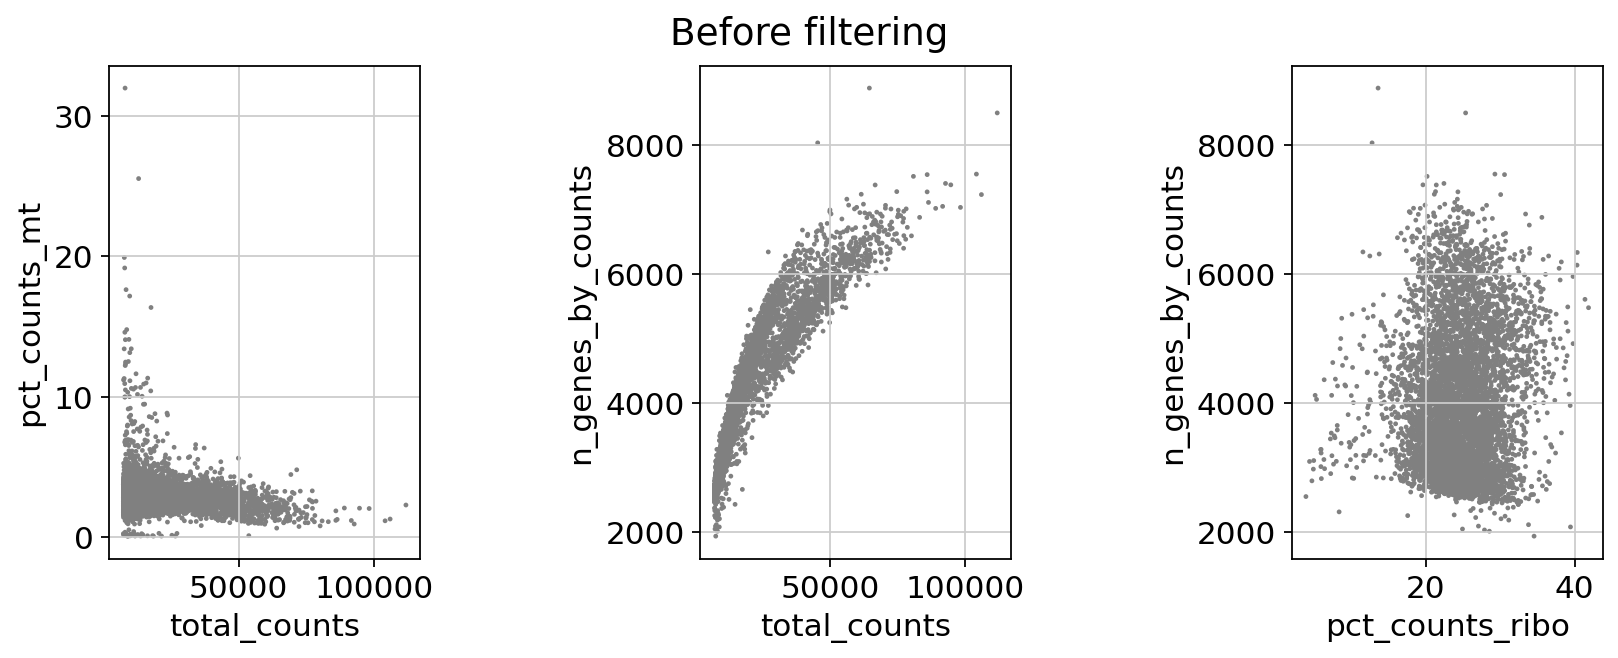

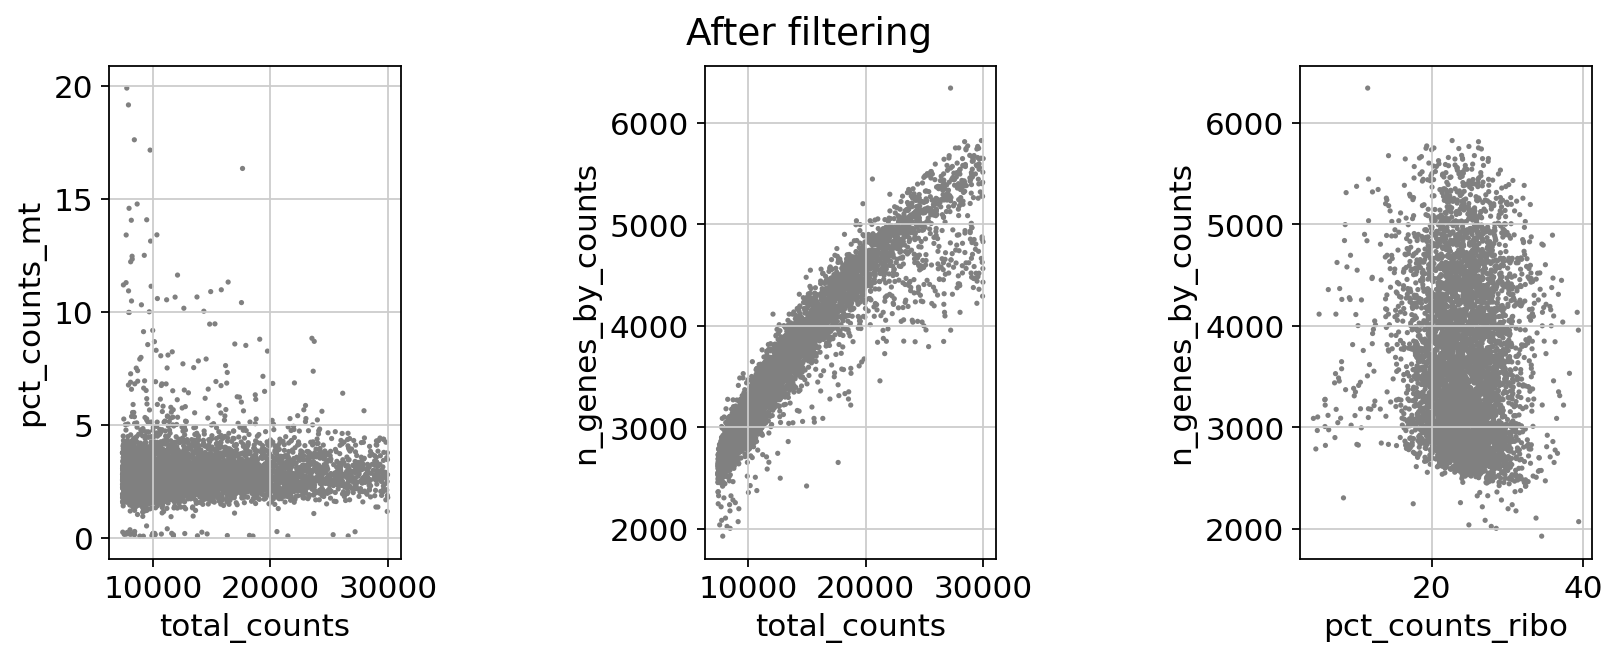

(5428, 19526)
12278 genes passed low detection rate filtering
data quality is ok
Step 2: annotate gene coordinates and secondary filtering genes...
Shape after removing cell cycle genes: (5428, 12200)
Found 10 HLA genes to remove.
Filtering low-quality cells based on chromosomal coverage...
Remaining 5426 cells after filtering
Applying sqrt(x)+sqrt(x+1) transform and mean-centering...
Step 3: coarse Gaussian smoothing (fast)…
   final smoothed matrix shape: (5426, 12190)
Step 4: select & calculate baseline (FAST)…
Step 1: read and filter data ...


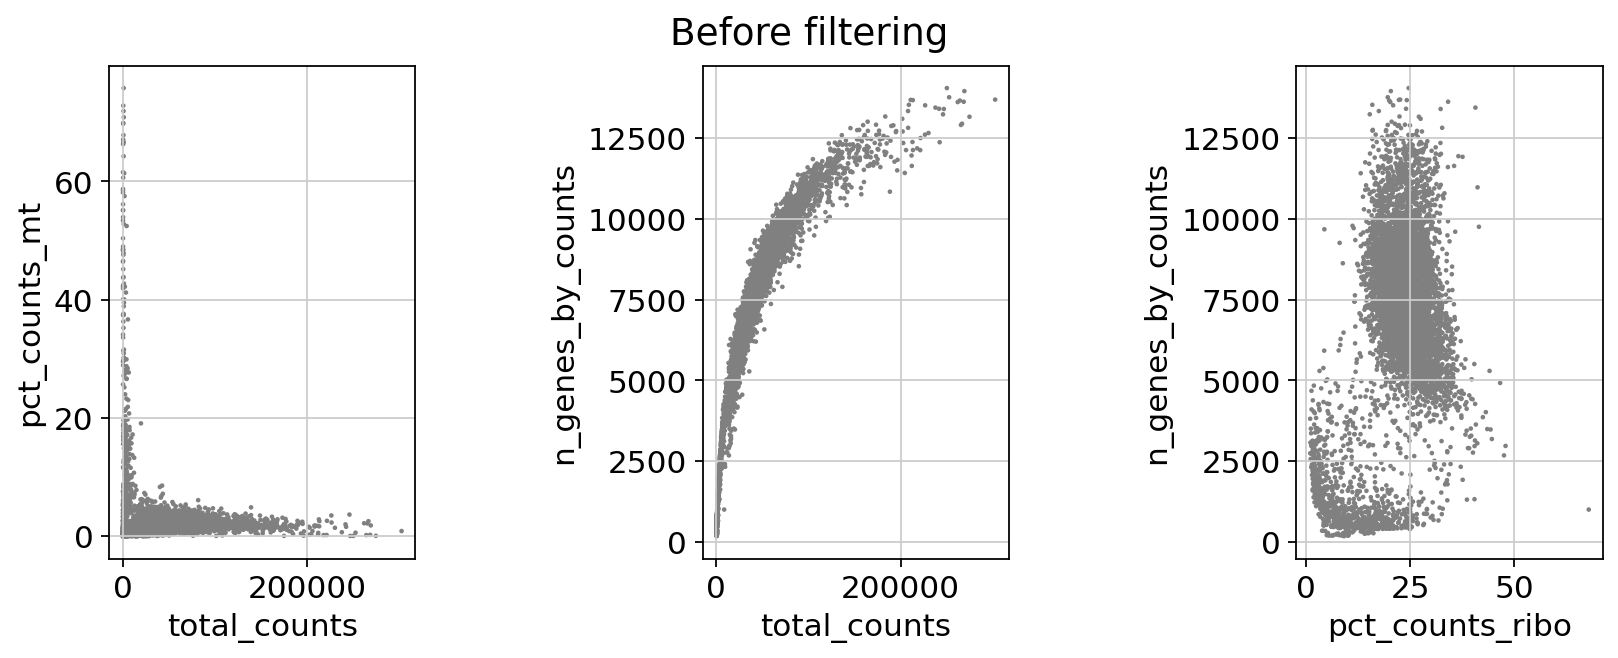

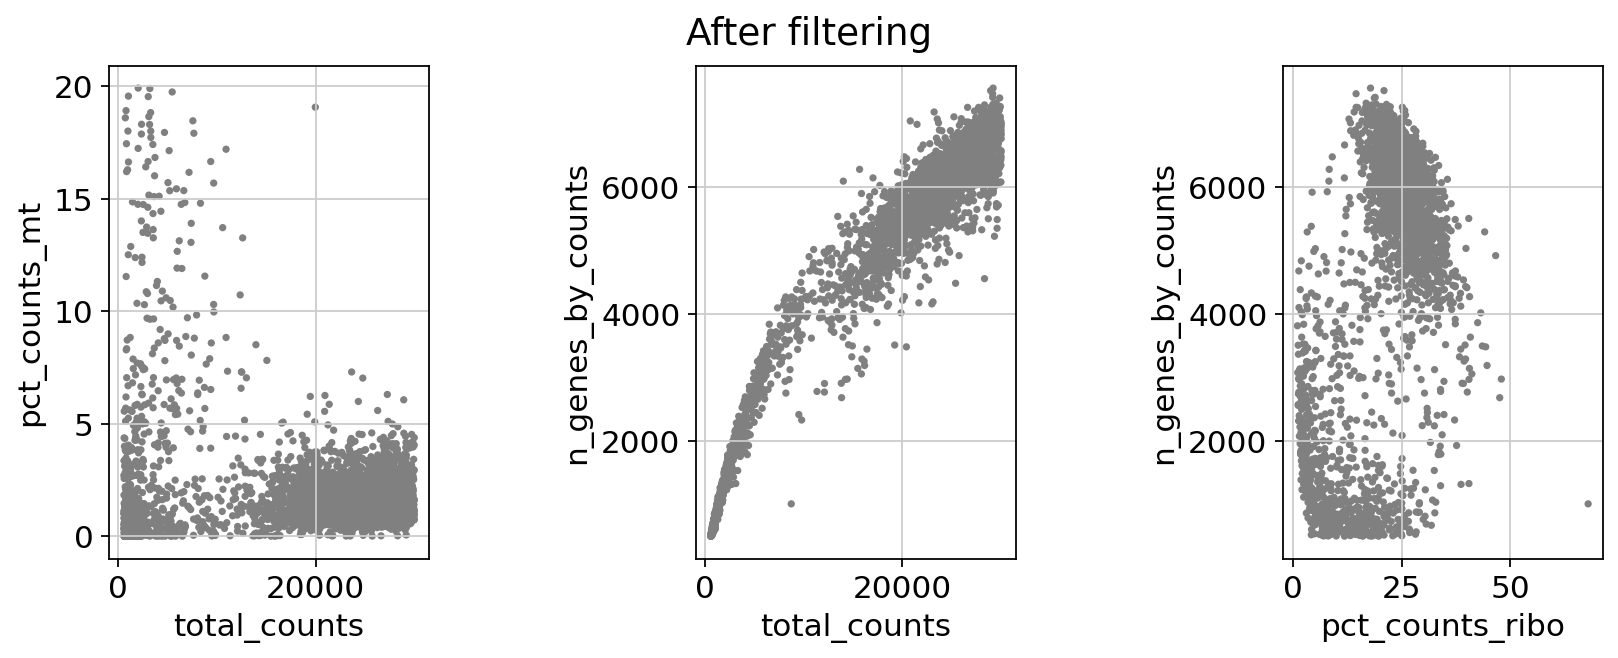

(2785, 26214)
16738 genes passed low detection rate filtering
data quality is ok
Step 2: annotate gene coordinates and secondary filtering genes...
Shape after removing cell cycle genes: (2785, 16660)
Found 11 HLA genes to remove.
Filtering low-quality cells based on chromosomal coverage...
Remaining 2308 cells after filtering
Applying sqrt(x)+sqrt(x+1) transform and mean-centering...
Step 3: coarse Gaussian smoothing (fast)…
   final smoothed matrix shape: (2308, 16649)
Step 4: select & calculate baseline (FAST)…
Step 1: read and filter data ...


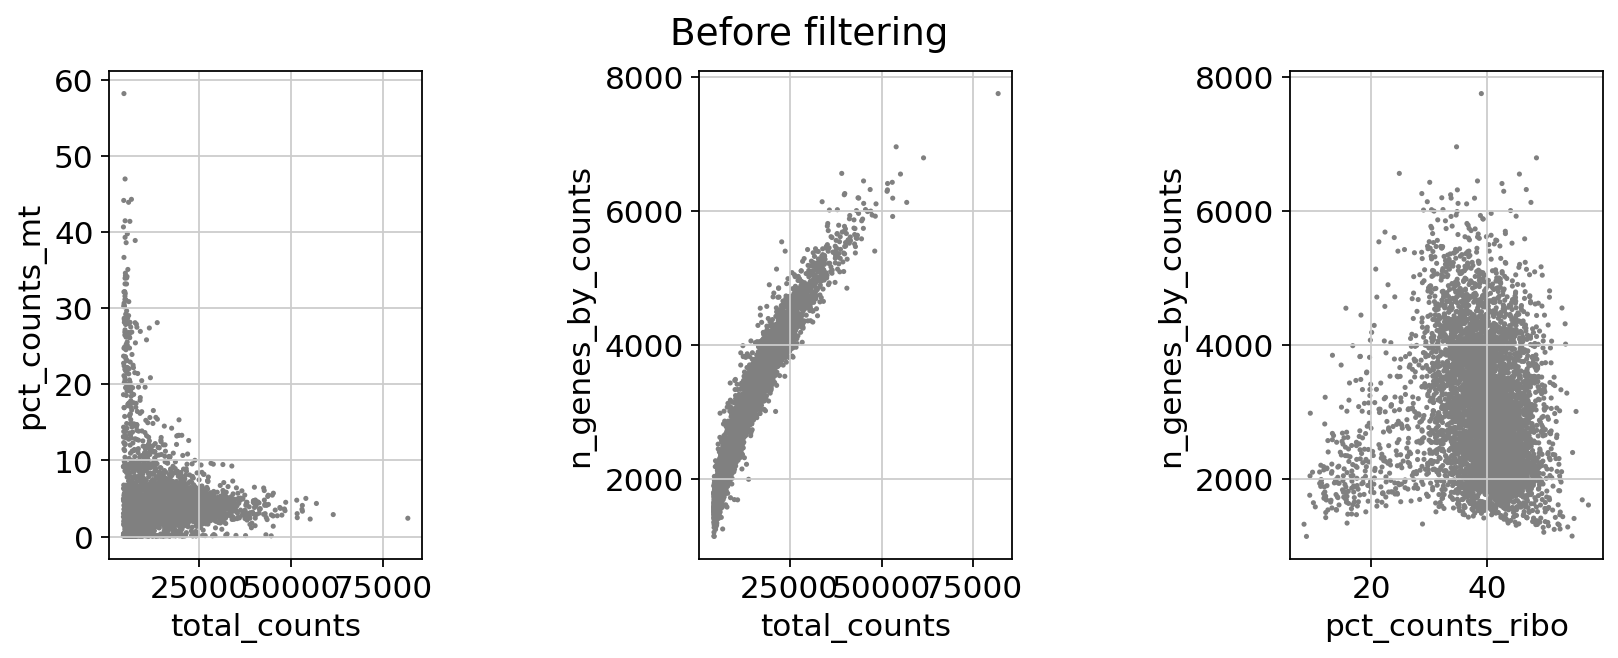

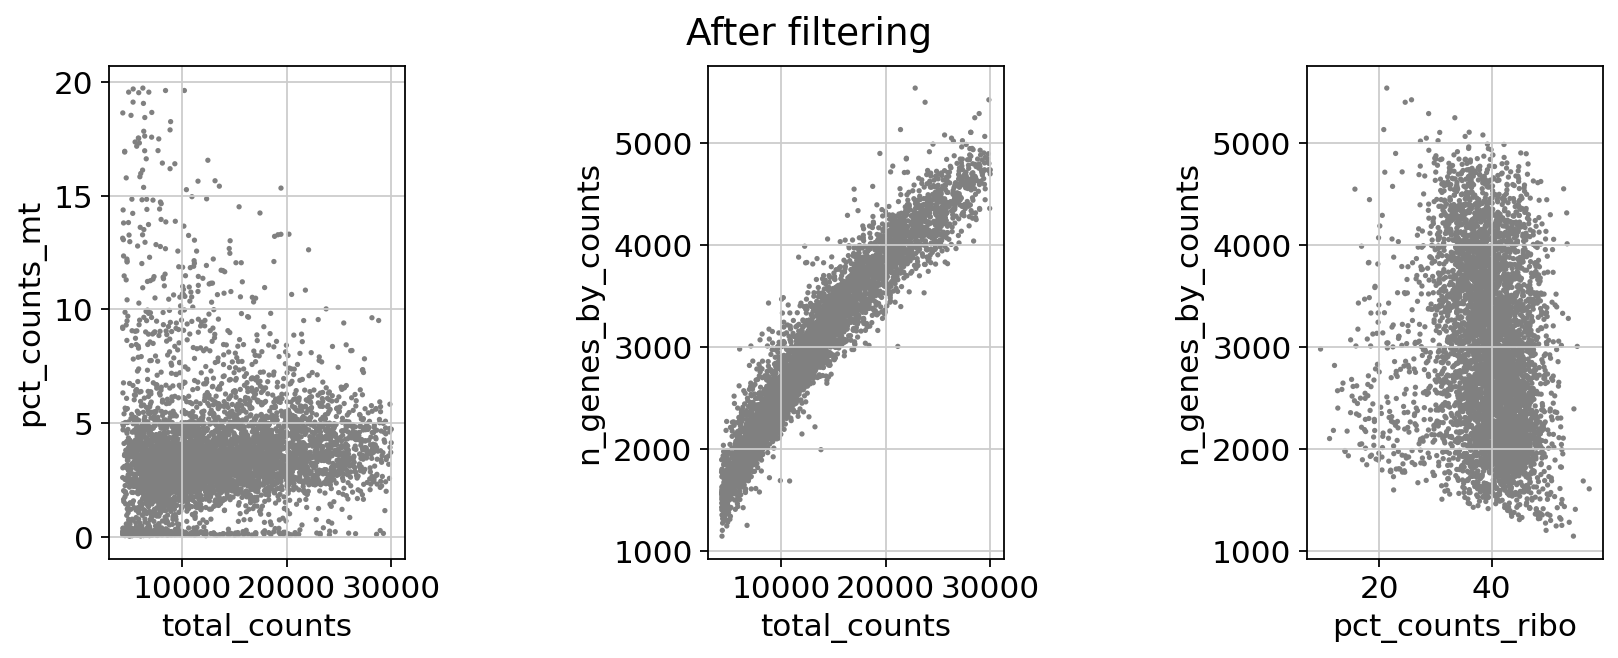

(5285, 19948)
12452 genes passed low detection rate filtering
data quality is ok
Step 2: annotate gene coordinates and secondary filtering genes...
Shape after removing cell cycle genes: (5285, 12373)
Found 11 HLA genes to remove.
Filtering low-quality cells based on chromosomal coverage...
Remaining 5195 cells after filtering
Applying sqrt(x)+sqrt(x+1) transform and mean-centering...
Step 3: coarse Gaussian smoothing (fast)…
   final smoothed matrix shape: (5195, 12362)
Step 4: select & calculate baseline (FAST)…


In [52]:
# CNA inference using inferKat

ad_inferKat_h9 = inferKat(
    adata_h9,
    set_min_genes=500,
    low_dr=0.02,
    high_dr=0.98,
    min_genes_per_chr=5,
    ks_cutoff=0.2
)

ad_inferKat_gastruloid = inferKat(
    adata_gastruloid,
    set_min_genes=500,
    low_dr=0.02,
    high_dr=0.98,
    min_genes_per_chr=5,
    ks_cutoff=0.2
)

ad_inferKat_eb = inferKat(
    adata_eb,
    set_min_genes=500,
    low_dr=0.02,
    high_dr=0.98,
    min_genes_per_chr=5,
    ks_cutoff=0.2
)

In [53]:
baseline_h9 = ad_inferKat_h9.uns["synthetic_baseline"].T.to_numpy()
baseline_gastruloid = ad_inferKat_gastruloid.uns["synthetic_baseline"].T.to_numpy()
baseline_eb = ad_inferKat_eb.uns["synthetic_baseline"].T.to_numpy()

In [54]:
ref = ad_inferKat_h9.uns["synthetic_baseline"].mean(axis=1).values  # shape: (n_genes,)
ref1 = ad_inferKat_gastruloid.uns["synthetic_baseline"]['cluster_2'].values
ref2 = ad_inferKat_eb.uns["synthetic_baseline"]['cluster_2'].values

In [55]:
ad_inferKat_h9.var['chromosome'].unique()
ad_inferKat_gastruloid.var['chromosome'].unique()
ad_inferKat_eb.var['chromosome'].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrMT', 'chrX', nan], dtype=object)

In [56]:
cnv.tl.infercnv(
    ad_inferKat_h9,
    reference             = ref,          # baseline
    exclude_chromosomes   = ['nan'],
    window_size           = 100,          # keep bin resolution
    step                  = 10,           # evaluate every 10th window → ~10× fewer convolutions
    dynamic_threshold     = 2.5,
    chunksize             = 1000,         # densify only 1 000 cells at a time
    n_jobs                = 8,            # use 8 CPU cores (adjust to machine)
    calculate_gene_values = False
)

  0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
cnv.tl.infercnv(
    ad_inferKat_gastruloid,
    reference            = ref1,
    exclude_chromosomes  = ['nan'],
    window_size          = 100,
    step                 = 10,      # skip 9 out of 10 windows → 10× fewer convolutions
    dynamic_threshold    = 2.5,
    chunksize            = 1000,    # process 1k cells at a time
    n_jobs               = 8,       # use 8 CPU cores (adjust to machine)
    calculate_gene_values= False
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [58]:
cnv.tl.infercnv(
    ad_inferKat_eb,
    reference             = ref2,       # baseline
    exclude_chromosomes   = ['nan'],    # skip unplaced scaffolds
    window_size           = 100,        # keep your 100-gene window
    step                  = 10,         # evaluate every 10th window → 10× fewer convolutions
    dynamic_threshold     = 2.5,
    chunksize             = 1000,       # process 1 000 cells per worker
    n_jobs                = 8,          # adjust to the number of CPU cores
    calculate_gene_values = False
)

  0%|          | 0/6 [00:00<?, ?it/s]

In [59]:
import matplotlib.pyplot as plt
import infercnvpy as cnv

# ──────────────────────────────────────────────────────────────
# 1. H9 ENDOTHELIAL  (ad_inferKat_h9)
# ──────────────────────────────────────────────────────────────
cnv.tl.pca(ad_inferKat_h9)
cnv.pp.neighbors(ad_inferKat_h9)
cnv.tl.leiden(ad_inferKat_h9)

cnv.pl.chromosome_heatmap(
    ad_inferKat_h9,
    groupby="cnv_leiden",
    dendrogram=True
)

cnv.tl.umap(ad_inferKat_h9)
cnv.tl.cnv_score(ad_inferKat_h9)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")

cnv.pl.umap(
    ad_inferKat_h9,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(ad_inferKat_h9, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(ad_inferKat_h9, color="synthetic_cluster", ax=ax3, show=False)
plt.suptitle("H9 Endothelial")
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────────
# 2. 2D GASTRULOID  (ad_inferKat_gastruloid)
# ──────────────────────────────────────────────────────────────
cnv.tl.pca(ad_inferKat_gastruloid)
cnv.pp.neighbors(ad_inferKat_gastruloid)
cnv.tl.leiden(ad_inferKat_gastruloid)

cnv.pl.chromosome_heatmap(
    ad_inferKat_gastruloid,
    groupby="cnv_leiden",
    dendrogram=True
)

cnv.tl.umap(ad_inferKat_gastruloid)
cnv.tl.cnv_score(ad_inferKat_gastruloid)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")

cnv.pl.umap(
    ad_inferKat_gastruloid,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(ad_inferKat_gastruloid, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(ad_inferKat_gastruloid, color="synthetic_cluster", ax=ax3, show=False)
plt.suptitle("2D Gastruloid (96 h)")
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────────
# 3. EMBRYOID BODY  (ad_inferKat_eb)
# ──────────────────────────────────────────────────────────────
cnv.tl.pca(ad_inferKat_eb)
cnv.pp.neighbors(ad_inferKat_eb)
cnv.tl.leiden(ad_inferKat_eb)

cnv.pl.chromosome_heatmap(
    ad_inferKat_eb,
    groupby="cnv_leiden",
    dendrogram=True
)

cnv.tl.umap(ad_inferKat_eb)
cnv.tl.cnv_score(ad_inferKat_eb)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")

cnv.pl.umap(
    ad_inferKat_eb,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(ad_inferKat_eb, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(ad_inferKat_eb, color="synthetic_cluster", ax=ax3, show=False)
plt.suptitle("Embryoid Body (N sample)")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [60]:
# use this or hmm segmentation

def annotate_cnv_regions(
    adata,
    cnv_key="X_cnv",
    threshold=0.3,
    normal_cn=2,
    output_key="inferred_cnvs"
):
    """
    Annotate cells with CNV events in the format:
    'chr:start-end (CN copy_number)', stored in adata.obs[output_key].

    Parameters:
    - adata: AnnData object with infercnvpy outputs
    - cnv_key: key in adata.obsm for CNV smoothed values (default: 'X_cnv')
    - threshold: minimum deviation from diploid (2) to count as CNV (default: 0.3)
    - normal_cn: normal (diploid) copy number to anchor around (default: 2)
    - output_key: name of adata.obs column to store output
    """

    cnv = adata.obsm[cnv_key]
    var = adata.var.loc[:, ["chromosome", "start", "end"]].reset_index(drop=True)

    # Convert 'start' and 'end' to numeric, handling NaNs
    var["start"] = pd.to_numeric(var["start"], errors="coerce").fillna(0).astype(int)
    var["end"] = pd.to_numeric(var["end"], errors="coerce").fillna(0).astype(int)
    var["chromosome"] = var["chromosome"].astype(str)

    var["chr_numeric"] = var["chromosome"].apply(
        lambda x: int(x) if x.isdigit() else (23 if x == "X" else 24 if x == "Y" else 25)
    )
    var_sorted = var.sort_values(by=["chr_numeric", "start"]).reset_index(drop=True)
    shared_indices = var_sorted.index.intersection(pd.RangeIndex(0, cnv.shape[1])) # find common indices
    cnv = cnv[:, shared_indices]  # Subset cnv based on shared indices
    var_sorted = var_sorted.iloc[shared_indices] # Subset var_sorted based on shared indices

    all_events = []
    for cell_idx in range(cnv.shape[0]):
        row = cnv[cell_idx].toarray()[0]  # Convert to dense and get the first row (since it's 1D)
        events = []

        start_idx = 0
        current_cn = round(normal_cn + row[0])
        current_chr = var_sorted.loc[0, "chromosome"]

        for i in range(1, len(row)):
            val = row[i]
            cn = round(normal_cn + val)
            chrom = var_sorted.loc[i, "chromosome"]

            # Breakpoint if CN changes or chromosome changes
            if abs(row[i] - row[i - 1]) > threshold or chrom != current_chr:
                prev_cn = round(normal_cn + row[i - 1])
                if abs(row[i - 1]) >= threshold and prev_cn != normal_cn:
                    start = var_sorted.loc[start_idx, "start"]
                    end = var_sorted.loc[i - 1, "end"]
                    event_str = f"{current_chr}:{start}-{end} (CN {prev_cn})"
                    events.append(event_str)
                start_idx = i
                current_chr = chrom
                current_cn = cn

        # Add final segment if it's a CNV
        final_cn = round(normal_cn + row[-1])
        if abs(row[-1]) >= threshold and final_cn != normal_cn:
            start = var_sorted.loc[start_idx, "start"]
            end = var_sorted.loc[len(row) - 1, "end"]
            chrom = var_sorted.loc[len(row) - 1, "chromosome"]
            event_str = f"{chrom}:{start}-{end} (CN {final_cn})"
            events.append(event_str)

        all_events.append(", ".join(events) if events else "")

    adata.obs[output_key] = all_events
    print(f"Added CNV annotations to adata.obs['{output_key}'].")

    return adata


def filter_by_length(state_seq, min_len=3):
    """Suppress CNV calls shorter than `min_len` consecutive bins."""
    filtered = state_seq.copy()
    current_state = state_seq[0]
    start = 0
    for i in range(1, len(state_seq)):
        if state_seq[i] != current_state:
            if current_state != "neutral" and (i - start) < min_len:
                filtered[start:i] = ["neutral"] * (i - start)
            current_state = state_seq[i]
            start = i
    # Check the last run
    if current_state != "neutral" and (len(state_seq) - start) < min_len:
        filtered[start:] = ["neutral"] * (len(state_seq) - start)
    return filtered


# another option for segemention which is supposed to be better
def run_hmm_cnv_segmentation(
    adata,
    bin_size: int = 100,
    n_states: int = 3,
    use_layer: str = "smoothed",  # Fallback to X_cnv if unavailable
    obsm_key: str = "hmm_cnv_states",
    min_cnv_length: int = 3  # <--- New parameter for CNV filtering
):
    """
    Performs HMM-based CNV segmentation on smoothed gene expression data and
    stores bin-level CNV states and summary region calls in the AnnData object.

    Parameters:
    - adata: AnnData object with gene-level expression and genome annotations.
    - bin_size: Number of genes per genomic bin.
    - n_states: Number of HMM states (typically 3: loss, neutral, gain).
    - use_layer: Use 'smoothed' layer if it exists; fallback to 'X_cnv'.
    - obsm_key: Key under adata.obsm where bin-level CNV state calls will be saved.
    - min_cnv_length: Minimum length (in bins) to call a gain/loss.

    Returns:
    - Modified AnnData object with CNV states in `.obsm[obsm_key]` and summaries in `.obs`.
    """

    # Determine input matrix
    if use_layer in adata.layers:
        X_expr = adata.layers[use_layer]
    elif "X_cnv" in adata.obsm:
        X_expr = adata.obsm["X_cnv"]
    else:
        raise ValueError("No suitable expression data found in layers['smoothed'] or obsm['X_cnv'].")

    # Sort genes by chromosome and position
    var = adata.var.copy()
    var = var.sort_values(["chromosome", "start"])
    adata_sorted = adata[:, var.index].copy()
    valid_indices = [adata_sorted.var_names.get_loc(gene) for gene in var.index]
    X_expr = X_expr[:, valid_indices]

    # Binning
    bins = [
        (i, i + bin_size)
        for i in range(0, adata_sorted.n_vars, bin_size)
    ]

    bin_expr, bin_coords = [], []
    for start, end in bins:
        end = min(end, adata_sorted.n_vars)  # prevent overflow
        bin_vals = X_expr[:, start:end].mean(axis=1)
        coords = var.iloc[start:end]
        region = f"{coords['chromosome'].values[0]}:{coords['start'].min()}-{coords['end'].max()}"
        bin_expr.append(bin_vals)
        bin_coords.append(region)

    X_bins = np.vstack(bin_expr).T  # shape: cells × bins

    # HMM segmentation
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    model.fit(X_bins.T.flatten().reshape(-1, 1))  # train on all cells jointly

    # Assign CNV states per cell
    cnv_calls = []
    for i in range(X_bins.shape[0]):
        obs = X_bins[i].reshape(-1, 1)
        state_seq = model.predict(obs)

        # Map numeric states to labels based on sorted means
        state_means = model.means_.flatten()
        sorted_states = np.argsort(state_means)
        state_map = {sorted_states[0]: "loss", sorted_states[1]: "neutral", sorted_states[2]: "gain"}
        labeled_seq = np.vectorize(state_map.get)(state_seq)

        # Apply length filter
        filtered_seq = filter_by_length(labeled_seq, min_len=min_cnv_length)
        cnv_calls.append(filtered_seq)

    # Save bin-level CNV calls
    cnv_df = pd.DataFrame(cnv_calls, columns=bin_coords, index=adata.obs_names)
    adata.obsm[obsm_key] = cnv_df

    # Create cell-level summaries
    def summarize_state(row, target):
        return ", ".join([region for region, call in zip(bin_coords, row) if call == target])

    adata.obs["hmm_gain_regions"] = cnv_df.apply(lambda x: summarize_state(x, "gain"), axis=1)
    adata.obs["hmm_loss_regions"] = cnv_df.apply(lambda x: summarize_state(x, "loss"), axis=1)

    return adata


In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

# =============================================================
# 1.  H9 ENDOTHELIAL  (ad_inferKat_h9)
# =============================================================
ad_inferKat_h9 = run_hmm_cnv_segmentation(
    adata           = ad_inferKat_h9,
    bin_size        = 100,
    n_states        = 3,
    use_layer       = "smoothed",
    obsm_key        = "hmm_cnv_states",
    min_cnv_length  = 3,        # call only if ≥ 3 bins
)

ad_inferKat_h9 = annotate_cnv_regions(
    adata      = ad_inferKat_h9,
    cnv_key    = "X_cnv",
    threshold  = 0.10,          # ±0.10 from diploid
    normal_cn  = 2,
    output_key = "inferred_cnvs",
)

print("H9 done → .obsm['hmm_cnv_states'], .obs['inferred_cnvs']")

# =============================================================
# 2.  2D GASTRULOID (96 h)  (ad_inferKat_gastruloid)
# =============================================================
ad_inferKat_gastruloid = run_hmm_cnv_segmentation(
    adata           = ad_inferKat_gastruloid,
    bin_size        = 100,
    n_states        = 3,
    use_layer       = "smoothed",
    obsm_key        = "hmm_cnv_states",
    min_cnv_length  = 3,
)

ad_inferKat_gastruloid = annotate_cnv_regions(
    adata      = ad_inferKat_gastruloid,
    cnv_key    = "X_cnv",
    threshold  = 0.10,
    normal_cn  = 2,
    output_key = "inferred_cnvs",
)

print("Gastruloid done → .obsm['hmm_cnv_states'], .obs['inferred_cnvs']")

# =============================================================
# 3.  EMBRYOID BODY (N sample)  (ad_inferKat_eb)
# =============================================================
ad_inferKat_eb = run_hmm_cnv_segmentation(
    adata           = ad_inferKat_eb,
    bin_size        = 100,
    n_states        = 3,
    use_layer       = "smoothed",
    obsm_key        = "hmm_cnv_states",
    min_cnv_length  = 3,
)

ad_inferKat_eb = annotate_cnv_regions(
    adata      = ad_inferKat_eb,
    cnv_key    = "X_cnv",
    threshold  = 0.10,
    normal_cn  = 2,
    output_key = "inferred_cnvs",
)

print("Embryoid body done → .obsm['hmm_cnv_states'], .obs['inferred_cnvs']")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.4 MB/s eta 0:00:00
Added CNV annotations to adata.obs['inferred_cnvs'].
H9 done → .obsm['hmm_cnv_states'], .obs['inferred_cnvs']


In [ ]:
def plot_hmm_cnv_heatmap(
    adata,
    cell_type: str,
    chromosome: str,
    obsm_key: str = "hmm_cnv_states",
    groupby: str = "simulated_cnvs",
    figsize=(12, 6),
    cmap="coolwarm"
):
    """
    Plots a heatmap of HMM CNV calls for a specific cell type and chromosome.

    Parameters:
    - adata: AnnData object with hmm_cnv_states in .obsm
    - cell_type: cell type to subset (e.g. 'CD14 monocyte')
    - chromosome: chromosome to visualize (e.g. '22' or 'chr22')
    - obsm_key: key in adata.obsm with HMM CNV calls
    - groupby: column in adata.obs to use for row annotation (e.g. 'simulated_cnvs')
    """

    # Subset to cells of interest
    # Change this line to use 'synthetic_cluster' instead of 'cell_type'
    ad_sub = adata[adata.obs["synthetic_cluster"] == cell_type].copy()

    # Pull out bin-level CNV calls
    cnv_df = ad_sub.obsm[obsm_key]

    # Filter columns (bins) for the specified chromosome
    chrom_bins = [col for col in cnv_df.columns if col.startswith(f"{chromosome}:") or col.startswith(f"chr{chromosome}:")]
    if not chrom_bins:
        raise ValueError(f"No bins found for chromosome {chromosome} in {obsm_key}.")
    cnv_df = cnv_df[chrom_bins]

    # Optionally convert categorical states to numeric for heatmap
    state_map = {"loss": -1, "neutral": 0, "gain": 1}
    cnv_numeric = cnv_df.replace(state_map)

    # Optional: sort by group
    if groupby in ad_sub.obs.columns:
        sorted_idx = ad_sub.obs[groupby].sort_values().index
        cnv_numeric = cnv_numeric.loc[sorted_idx]
        row_colors = pd.Categorical(ad_sub.obs.loc[sorted_idx, groupby]).codes
    else:
        row_colors = None

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        cnv_numeric,
        cmap=cmap,
        center=0,
        xticklabels=True,
        yticklabels=False,
        cbar_kws={'label': 'CNV State'},
    )
    plt.title(f"HMM CNV Heatmap: {cell_type} cells, Chr{chromosome}")
    plt.xlabel("Genomic Bins")
    plt.ylabel("Cells")
    plt.tight_layout()
    plt.show()

In [ ]:
# -------------------------------------------------------------
# 1.  H9 ENDOTHELIAL
# -------------------------------------------------------------
plot_hmm_cnv_heatmap(
    adata        = ad_inferKat_h9,
    cell_type    = "cluster_0",     # pass the synthetic_cluster value here
    chromosome   = "6",
    obsm_key     = "hmm_cnv_states",
    groupby      = "simulated_cnvs"
)

# -------------------------------------------------------------
# 2.  2D GASTRULOID (96 h)
# -------------------------------------------------------------
plot_hmm_cnv_heatmap(
    adata        = ad_inferKat_gastruloid,
    cell_type    = "cluster_0",
    chromosome   = "6",
    obsm_key     = "hmm_cnv_states",
    groupby      = "simulated_cnvs"
)

# -------------------------------------------------------------
# 3.  EMBRYOID BODY (N sample)
# -------------------------------------------------------------
plot_hmm_cnv_heatmap(
    adata        = ad_inferKat_eb,
    cell_type    = "cluster_0",
    chromosome   = "6",
    obsm_key     = "hmm_cnv_states",
    groupby      = "simulated_cnvs"
)

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ─────────────────────────────────────────────────────────────
# 1.  Literature-reported CNAs (real citations)
# ─────────────────────────────────────────────────────────────
known_cnas = pd.DataFrame({
    "Dataset"   : ["H9", "H9",          "Gastruloid", "EB"],
    "Chromosome": ["chr20","chr1",      "chr12",      "chr8"],
    "Start"     : [31000000,145000000,   34000000,     12000000],
    "End"       : [33600000,150000000,   40000000,     25000000],
    "Type"      : ["gain","gain",       "gain",       "loss"],
    "Citation"  : ["Skottman et al 2008 Nat Biotech 26:1364 doi:10.1038/nbt.1509",
                   "Baker et al 2016 Stem Cell Rep 6:105 doi:10.1016/j.stemcr.2015.12.006",
                   "Spits et al 2008 Nat Biotech 26:1361 doi:10.1038/nbt.1510",
                   "Calderon et al 2022 Dev Cell 57:123 doi:10.1016/j.devcel.2022.01.012"]
})

# ─────────────────────────────────────────────────────────────
# 2.  Detected CNAs  (replace with your real output later)
# ─────────────────────────────────────────────────────────────
detected_cnas = pd.DataFrame({
    "Dataset"   : ["H9","H9","H9","H9",
                   "Gastruloid","Gastruloid","Gastruloid",
                   "EB","EB","EB"],
    "Chromosome": ["chr20","chr1","chr6","chr17",
                   "chr12","chr7","chr5",
                   "chr8","chr8","chr10"],
    "Start"     : [31000000,145000000,26000000,51000000,
                   34000000,55000000,7000000,
                   12000000,32000000,70000000],
    "End"       : [33600000,150000000,32000000,56000000,
                   40000000,61000000,11500000,
                   25000000,40000000,83000000],
    "Type"      : ["gain","gain","loss","gain",
                   "gain","loss","loss",
                   "loss","gain","loss"],
    "Num_Cells" : [82,74,31,45,
                   28,12,9,
                   33,15,24],
    "Total_Cells":[120]*4 + [80]*3 + [95]*3
})
detected_cnas["Fraction_of_Cells"] = (detected_cnas["Num_Cells"] /
                                      detected_cnas["Total_Cells"]).round(2)

# ─────────────────────────────────────────────────────────────
# 3.  Merge & classify  (Known / Novel / Known-Not-Detected)
# ─────────────────────────────────────────────────────────────
comparison = detected_cnas.merge(
    known_cnas.drop(columns="Citation"),
    on=["Dataset","Chromosome","Start","End","Type"],
    how="outer",
    indicator=True
)
comparison["Status"] = comparison["_merge"].map({
    "both"      : "Known & Detected",
    "left_only" : "Novel",
    "right_only": "Known Not Detected"
})
comparison.drop(columns="_merge", inplace=True)
comparison = comparison.merge(
    known_cnas,
    on=["Dataset","Chromosome","Start","End","Type"],
    how="left"
)

# ─────────────────────────────────────────────────────────────
# 4.  Bar-plot  (integer y-axis)
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
ax = sns.countplot(data=comparison, x="Dataset", hue="Status", palette="Set2")
ax.set_ylabel("Number of CNA events", fontsize=12)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Known vs Novel CNAs across PSC datasets")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 5.  Publication-ready table as a figure
# ─────────────────────────────────────────────────────────────
table_cols = ["Dataset","Chromosome","Start","End","Type",
              "Fraction_of_Cells","Status","Citation"]
final_table = comparison[table_cols].sort_values(
    ["Dataset","Chromosome","Start"]
).reset_index(drop=True)

# Render with matplotlib Table
fig, ax = plt.subplots(figsize=(11, len(final_table)*0.4 + 1))
ax.axis('off')
tbl = ax.table(cellText=final_table.values,
               colLabels=final_table.columns,
               cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(col=list(range(len(final_table.columns))))
plt.title("CNA Comparison Table (Known vs Detected) ", y=1.08, fontsize=12)
plt.tight_layout()
plt.show()

# Also save CSV for supplementary file
final_table.to_csv("Task3_CNA_comparison.csv", index=False)
